c:\Users\FA004\Desktop\satimg2\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🌃 NIGHTLIGHT ENERGY PREDICTION SYSTEM
🔥 PyTorch version: 2.9.0+cu126
🎮 CUDA available: True
📦 timm version: 1.0.21

🌃 NIGHTLIGHT SATELLITE IMAGE ENERGY PREDICTION
Architecture: Swin + Spatial Attention + Tabular + Bright Spots
Features: 17 tabular + 5 bright spot statistics
NO DATA LEAKAGE - Proper temporal features

✅ CUDA Device: NVIDIA GeForce RTX 4070 Ti SUPER


📊 LOADING DATA AND ENGINEERING FEATURES
   Initial rows: 10842
   After filtering: 10842
   ✅ Data sorted by Country and Date (temporal ordering)

🔧 Engineering 17 features (NO data leakage)...
   ✅ Log transforms: log_population, log_area, log_density
   ✅ Time features: month_sin, month_cos, year_normalized
   🔧 Creating lag features (using PAST target values)...
   ✅ Lag features: energy_lag_1, 2, 3, 6, 12
   🔧 Creating rolling statistics (using PAST windows)...
   ✅ Rolling stats: mean/std for 3, 6, 12 months

   📋 Final Feature Summary:
      - Log transforms: 3
      - Time features: 3
      - Lag features: 5 (autoreg

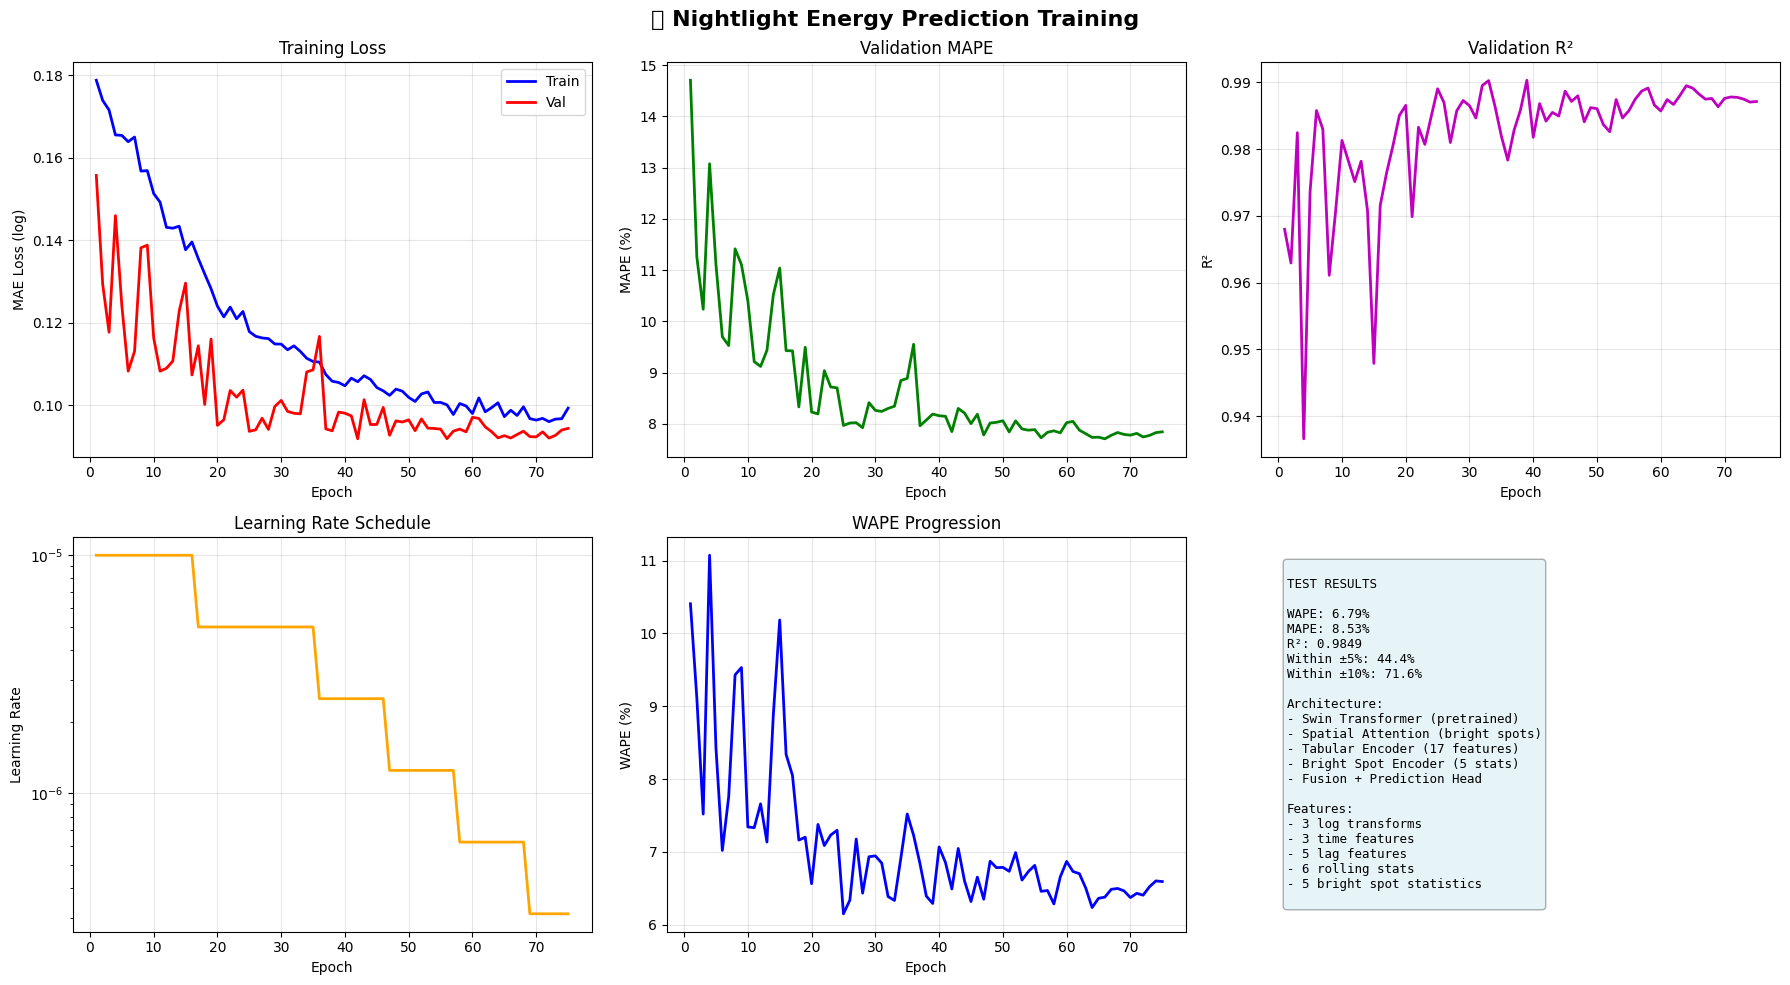


✅ TRAINING COMPLETE!
🎯 Final Test WAPE: 6.79%
📈 Final Test R²: 0.9849


In [1]:
# -*- coding: utf-8 -*-
"""
Nightlight Satellite Image + Tabular Features → Energy Use per Capita Prediction
Enhanced with Spatial Attention for Bright Spots (Urban Centers)
NO DATA LEAKAGE - Proper Temporal Features
"""

import os
import pandas as pd
import numpy as np
import rasterio
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import RandomRotation, RandomHorizontalFlip
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
import cv2
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import timm


warnings.filterwarnings('ignore')

print("="*80)
print("🌃 NIGHTLIGHT ENERGY PREDICTION SYSTEM")
print("="*80)
print(f"🔥 PyTorch version: {torch.__version__}")
print(f"🎮 CUDA available: {torch.cuda.is_available()}")
print(f"📦 timm version: {timm.__version__}")
print("="*80)


# ============================================================================
# SPATIAL ATTENTION MODULE FOR BRIGHT SPOTS
# ============================================================================

class SpatialAttentionModule(nn.Module):
    """
    Spatial Attention to focus on bright spots (urban centers) in nightlight images.
    This helps the model focus on areas with high energy consumption.
    """
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # x: (B, C, H, W)
        avg_out = torch.mean(x, dim=1, keepdim=True)  # (B, 1, H, W)
        max_out, _ = torch.max(x, dim=1, keepdim=True)  # (B, 1, H, W)
        
        # Concatenate along channel dimension
        combined = torch.cat([avg_out, max_out], dim=1)  # (B, 2, H, W)
        
        # Generate attention map
        attention = self.sigmoid(self.conv(combined))  # (B, 1, H, W)
        
        # Apply attention
        return x * attention


class BrightSpotEncoder(nn.Module):
    """
    Additional encoder specifically for bright spot statistics.
    Extracts max intensity, mean bright region intensity, etc.
    """
    def __init__(self, output_dim=64):
        super().__init__()
        # 5 statistics: max, mean, std, 90th percentile, bright pixel count
        self.encoder = nn.Sequential(
            nn.Linear(5, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, output_dim)
        )
    
    def forward(self, x):
        return self.encoder(x)


# ============================================================================
# TABULAR FEATURE ENCODER
# ============================================================================

class TabularEncoder(nn.Module):
    """
    Enhanced tabular encoder - NO DATA LEAKAGE
    Features (17 total):
    - 3 log transforms: log_population, log_area, log_density
    - 3 time features: month_sin, month_cos, year_normalized
    - 5 lag features: energy_lag_1, energy_lag_2, energy_lag_3, energy_lag_6, energy_lag_12
    - 6 rolling stats: energy_rolling_mean_3/6/12, energy_rolling_std_3/6/12
    """
    def __init__(self, num_features=17, output_dim=512, dropout=0.3):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, output_dim)
        )
    
    def forward(self, x):
        x = x.float()
        x = torch.nan_to_num(x, nan=0.0, posinf=1.0, neginf=-1.0)
        return self.encoder(x)


# ============================================================================
# FUSION LAYER
# ============================================================================

class FusionLayer(nn.Module):
    """Enhanced fusion with attention on bright spot features"""
    def __init__(self, vision_dim=512, tabular_dim=512, brightspot_dim=64, 
                 output_dim=512, dropout=0.3):
        super().__init__()
        
        total_dim = vision_dim + tabular_dim + brightspot_dim
        
        self.fusion = nn.Sequential(
            nn.Linear(total_dim, 1024),
            nn.LayerNorm(1024),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(1024, output_dim),
            nn.LayerNorm(output_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
    
    def forward(self, vision_feat, tabular_feat, brightspot_feat):
        combined = torch.cat([vision_feat, tabular_feat, brightspot_feat], dim=-1)
        return self.fusion(combined)


# ============================================================================
# MAIN MULTIMODAL MODEL
# ============================================================================

class NightlightEnergyPredictor(nn.Module):
    """
    Swin Transformer + Spatial Attention + Tabular + Bright Spot Features
    Architecture:
    1. Swin Transformer (pretrained) → 768-dim
    2. Spatial Attention Module (focuses on bright spots)
    3. Vision Projection → 512-dim
    4. Tabular Encoder (17 features) → 512-dim
    5. Bright Spot Encoder (5 statistics) → 64-dim
    6. Fusion (concat + MLP) → 512-dim
    7. Prediction Head → 1
    """
    def __init__(self,
                 swin_variant='swin_tiny_patch4_window7_224',
                 num_tabular_features=17,
                 dropout=0.3,
                 pretrained=True):
        super().__init__()
        
        print(f"\n🔨 Building Nightlight Energy Predictor...")
        print(f"   Vision: {swin_variant}")
        print(f"   Tabular features: {num_tabular_features}")
        print(f"   Pretrained: {pretrained}")
        
        # 1. Swin Transformer
        self.swin = timm.create_model(
            swin_variant,
            pretrained=pretrained,
            num_classes=0,
            global_pool='avg',
            in_chans=1,
            img_size=64
        )
        
        swin_out_dim = self.swin.num_features
        print(f"   Swin output dim: {swin_out_dim}")
        
        # 2. Spatial Attention (focuses on bright spots)
        self.spatial_attention = SpatialAttentionModule(kernel_size=7)
        
        # 3. Vision projection
        self.vision_proj = nn.Sequential(
            nn.Linear(swin_out_dim, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # 4. Tabular encoder
        self.tabular_encoder = TabularEncoder(
            num_features=num_tabular_features,
            output_dim=512,
            dropout=dropout
        )
        
        # 5. Bright spot encoder
        self.brightspot_encoder = BrightSpotEncoder(output_dim=64)
        
        # 6. Fusion layer
        self.fusion = FusionLayer(
            vision_dim=512,
            tabular_dim=512,
            brightspot_dim=64,
            output_dim=512,
            dropout=dropout
        )
        
        # 7. Prediction head
        self.head = nn.Sequential(
            nn.Linear(512, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 1)
        )
        
        print(f"   ✅ Model built with spatial attention for bright spots!")
    
    def freeze_backbone(self):
        """Freeze ONLY Swin backbone"""
        for p in self.swin.parameters():
            p.requires_grad = False
        print("   🔒 Swin backbone frozen")
    
    def unfreeze_all(self):
        """Unfreeze everything"""
        for p in self.parameters():
            p.requires_grad = True
        print("   🔓 All parameters unfrozen")
    
    def forward(self, img, tabular, brightspot_stats):
        """
        Args:
            img: (B, 1, 64, 64) - nightlight images
            tabular: (B, 17) - enhanced features (NO target leakage)
            brightspot_stats: (B, 5) - bright spot statistics
        Returns:
            predictions: (B, 1)
        """
        # Apply spatial attention before Swin
        img_attended = self.spatial_attention(img)
        
        # Vision features
        vision_feat = self.swin(img_attended)
        vision_feat = self.vision_proj(vision_feat)
        
        # Tabular features
        tabular_feat = self.tabular_encoder(tabular)
        
        # Bright spot features
        brightspot_feat = self.brightspot_encoder(brightspot_stats)
        
        # Fusion
        fused = self.fusion(vision_feat, tabular_feat, brightspot_feat)
        
        # Prediction
        output = self.head(fused)
        return output


# ============================================================================
# DATA LOADING AND FEATURE ENGINEERING
# ============================================================================

def extract_brightspot_statistics(image):
    """
    Extract statistics from bright spots (urban centers) in nightlight image.
    Returns 5 features:
    1. Maximum intensity
    2. Mean of pixels above 75th percentile
    3. Std of bright pixels
    4. 90th percentile value
    5. Percentage of bright pixels (above 75th percentile)
    """
    # Flatten image
    flat = image.flatten()
    
    # Calculate thresholds
    p75 = np.percentile(flat, 75)
    p90 = np.percentile(flat, 90)
    
    # Bright pixels
    bright_mask = flat >= p75
    bright_pixels = flat[bright_mask]
    
    # Statistics
    max_intensity = flat.max()
    mean_bright = bright_pixels.mean() if len(bright_pixels) > 0 else 0
    std_bright = bright_pixels.std() if len(bright_pixels) > 0 else 0
    pct_bright = (len(bright_pixels) / len(flat)) * 100
    
    return [max_intensity, mean_bright, std_bright, p90, pct_bright]


def load_data_with_features(csv_path, image_dir):
    """
    Load images + tabular features + bright spot statistics
    NO DATA LEAKAGE - excludes 'Electricity consumption or Demand (TWh)'
    """
    print("\n" + "="*80)
    print("📊 LOADING DATA AND ENGINEERING FEATURES")
    print("="*80)
    
    # Load CSV
    df = pd.read_csv(csv_path)
    print(f"   Initial rows: {len(df)}")
    
    # Filter valid data
    df = df[(df['Energy Use per Capita (kWh)'] > 0) & 
            (df['Population'] > 0) & 
            (df['Area (Sq. Km)'] > 0)].copy()
    print(f"   After filtering: {len(df)}")
    
    # Parse dates
    df['date'] = pd.to_datetime(df['Date (month/year)'])
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    
    # CRITICAL: Sort by country and date for proper temporal ordering
    df = df.sort_values(['Country', 'date']).reset_index(drop=True)
    print(f"   ✅ Data sorted by Country and Date (temporal ordering)")
    
    # Convert to numeric
    for col in ['Population', 'Area (Sq. Km)']:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
    
    # ========== FEATURE ENGINEERING (17 features) ==========
    print("\n🔧 Engineering 17 features (NO data leakage)...")
    
    # 1. Log transforms (3 features)
    df['log_population'] = np.log1p(df['Population'].astype(float))
    df['log_area'] = np.log1p(df['Area (Sq. Km)'].astype(float))
    df['density'] = df['Population'].astype(float) / (df['Area (Sq. Km)'].astype(float) + 1)
    df['log_density'] = np.log1p(df['density'])
    print("   ✅ Log transforms: log_population, log_area, log_density")
    
    # Store target for lag features (NOT used as direct feature)
    df['per_capita'] = df['Energy Use per Capita (kWh)'].astype(float)
    
    # 2. Time features (3 features)
    df['month_sin'] = np.sin(2 * np.pi * df['month'].astype(float) / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'].astype(float) / 12)
    year_min = df['year'].min()
    year_max = df['year'].max()
    df['year_normalized'] = (df['year'].astype(float) - year_min) / (year_max - year_min + 1e-8)
    print("   ✅ Time features: month_sin, month_cos, year_normalized")
    
    # 3. Lag features (5 features) - NO LEAKAGE
    # These use PAST energy consumption (shifted to avoid leakage)
    print("   🔧 Creating lag features (using PAST target values)...")
    for lag in [1, 2, 3, 6, 12]:
        df[f'energy_lag_{lag}'] = df.groupby('Country')['per_capita'].shift(lag)
    print("   ✅ Lag features: energy_lag_1, 2, 3, 6, 12")
    
    # 4. Rolling statistics (6 features) - NO LEAKAGE
    # Mean and std over PAST 3, 6, 12 months
    print("   🔧 Creating rolling statistics (using PAST windows)...")
    for window in [3, 6, 12]:
        df[f'energy_rolling_mean_{window}'] = df.groupby('Country')['per_capita'].transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=1).mean()
        )
        df[f'energy_rolling_std_{window}'] = df.groupby('Country')['per_capita'].transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=1).std()
        )
    print("   ✅ Rolling stats: mean/std for 3, 6, 12 months")
    
    # Fill NaN values created by lag/rolling operations
    lag_cols = [f'energy_lag_{lag}' for lag in [1, 2, 3, 6, 12]]
    rolling_cols = [f'energy_rolling_mean_{w}' for w in [3, 6, 12]] + \
                   [f'energy_rolling_std_{w}' for w in [3, 6, 12]]
    
    df[lag_cols + rolling_cols] = df[lag_cols + rolling_cols].fillna(0)
    
    # Final feature list (17 features)
    feature_cols = [
        # Log transforms (3)
        'log_population', 'log_area', 'log_density',
        # Time features (3)
        'month_sin', 'month_cos', 'year_normalized',
        # Lag features (5)
        'energy_lag_1', 'energy_lag_2', 'energy_lag_3', 'energy_lag_6', 'energy_lag_12',
        # Rolling statistics (6)
        'energy_rolling_mean_3', 'energy_rolling_mean_6', 'energy_rolling_mean_12',
        'energy_rolling_std_3', 'energy_rolling_std_6', 'energy_rolling_std_12'
    ]
    
    print(f"\n   📋 Final Feature Summary:")
    print(f"      - Log transforms: 3")
    print(f"      - Time features: 3")
    print(f"      - Lag features: 5 (autoregressive from PAST targets)")
    print(f"      - Rolling stats: 6 (from PAST windows)")
    print(f"      - Total: 17 features")
    print(f"      ❌ Excluded: 'Electricity consumption or Demand (TWh)' (would cause leakage)")
    
    # ========== LOAD IMAGES AND EXTRACT BRIGHT SPOT STATISTICS ==========
    print("\n🖼️ Loading images and extracting bright spot statistics...")
    
    raw_images, features, targets, years, brightspot_stats = [], [], [], [], []
    skipped = 0
    
    for idx, row in df.iterrows():
        img_path = os.path.join(image_dir, row['Country'],
                                f"{row['Country']}_{row['year']}_{row['month']:02d}.tif")
        
        if not os.path.exists(img_path):
            skipped += 1
            continue
        
        try:
            with rasterio.open(img_path) as src:
                image = src.read(1)
                
                # Check for corrupted/invalid images
                if image is None:
                    skipped += 1
                    continue
                
                # Check for NaN/Inf values
                if np.isnan(image).any() or np.isinf(image).any():
                    skipped += 1
                    continue
                
                # Check for all-zero images (corrupted)
                if np.all(image == 0):
                    skipped += 1
                    continue
                
                # Check for invalid value ranges (nightlight should be non-negative)
                if image.min() < 0:
                    skipped += 1
                    continue
                
                # Check for suspiciously uniform images (likely corrupted)
                if image.std() < 1e-6:
                    skipped += 1
                    continue
                
                # Extract bright spot statistics BEFORE resizing (more accurate)
                bs_stats = extract_brightspot_statistics(image)
                
                # Resize for model
                image = cv2.resize(image, (64, 64), interpolation=cv2.INTER_LINEAR)
                
                # Get feature values
                feature_vals = [float(row[col]) for col in feature_cols]
                
                # Validate features
                if any(np.isnan(v) or np.isinf(v) for v in feature_vals):
                    skipped += 1
                    continue
                
                # Get target
                target_val = row['Energy Use per Capita (kWh)']
                if np.isnan(target_val) or np.isinf(target_val) or target_val <= 0:
                    skipped += 1
                    continue
                
                raw_images.append(image)
                features.append(feature_vals)
                targets.append([target_val])
                years.append(row['year'])
                brightspot_stats.append(bs_stats)
        
        except Exception as e:
            skipped += 1
            continue
    
    print(f"\n   ✅ Successfully loaded: {len(raw_images)} samples")
    print(f"   ⚠️  Skipped: {skipped}")
    
    if len(raw_images) == 0:
        raise ValueError("❌ No valid data loaded!")
    
    # ========== PREPARE IMAGES (NO NORMALIZATION YET) ==========
    # Normalization will be done AFTER train/test split to prevent data leakage!
    print("\n📦 Preparing images (normalization deferred to prevent leakage)...")
    
    images = []
    for img in raw_images:
        # Just add channel dimension, no normalization
        images.append(img[np.newaxis, :, :])
    
    images = np.stack(images)
    features = np.array(features)
    targets = np.array(targets)
    years = np.array(years)
    brightspot_stats = np.array(brightspot_stats)
    
    # Log-transform targets
    print(f"\n📊 Target transformation:")
    print(f"   Original range: [{targets.min():.2f}, {targets.max():.2f}] kWh")
    targets_log = np.log1p(targets)
    print(f"   Log-transformed range: [{targets_log.min():.2f}, {targets_log.max():.2f}]")
    
    print("="*80)
    return images, features, targets_log, years, brightspot_stats


# ============================================================================
# IMAGE NORMALIZATION (USING ONLY TRAINING DATA)
# ============================================================================

def normalize_images(train_images, val_images, test_images):
    """
    Normalize images using ONLY training set statistics to prevent data leakage.
    
    Args:
        train_images: (N_train, 1, 64, 64) - raw training images
        val_images: (N_val, 1, 64, 64) - raw validation images
        test_images: (N_test, 1, 64, 64) - raw test images
    
    Returns:
        Normalized images and normalization statistics
    """
    print("\n" + "="*80)
    print("🎨 NORMALIZING IMAGES (USING ONLY TRAINING DATA)")
    print("="*80)
    
    # Compute statistics ONLY from training data
    train_pixels = np.concatenate([img.flatten() for img in train_images])
    global_min = np.percentile(train_pixels, 1)
    global_max = np.percentile(train_pixels, 99)
    
    print(f"   Training data statistics:")
    print(f"      Min (1st percentile): {global_min:.2f}")
    print(f"      Max (99th percentile): {global_max:.2f}")
    print(f"   ✅ These statistics will be applied to all splits")
    
    # Normalize all splits using training statistics
    def normalize_split(images, split_name):
        normalized = []
        for img in images:
            norm_img = np.clip((img - global_min) / (global_max - global_min + 1e-8), 0, 1)
            norm_img = np.nan_to_num(norm_img, nan=0.0, posinf=1.0, neginf=0.0)
            normalized.append(norm_img)
        normalized = np.stack(normalized)
        print(f"   {split_name}: {len(images)} images normalized")
        return normalized
    
    train_norm = normalize_split(train_images, "Train")
    val_norm = normalize_split(val_images, "Val")
    test_norm = normalize_split(test_images, "Test")
    
    print("="*80)
    
    return train_norm, val_norm, test_norm, (global_min, global_max)


# ============================================================================
# DATASET
# ============================================================================

class AddNoise:
    def __init__(self, std=0.01):
        self.std = std
    def __call__(self, x):
        return x + torch.randn_like(x) * self.std


class MultimodalDataset(Dataset):
    """Dataset with images + tabular features + bright spot statistics"""
    def __init__(self, images, features, brightspot_stats, targets=None, augment=False):
        self.images = torch.FloatTensor(images)
        self.features = torch.FloatTensor(features)
        self.brightspot_stats = torch.FloatTensor(brightspot_stats)
        self.targets = torch.FloatTensor(targets) if targets is not None else None
        self.augment = augment
        
        if augment:
            self.transforms = transforms.Compose([
                RandomRotation(10),
                RandomHorizontalFlip(p=0.5),
                transforms.RandomApply([AddNoise(0.01)], p=0.3)
            ])
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img = self.images[idx]
        if self.augment and self.transforms:
            img = self.transforms(img.unsqueeze(0)).squeeze(0)
        
        if self.targets is not None:
            return img, self.features[idx], self.brightspot_stats[idx], self.targets[idx]
        return img, self.features[idx], self.brightspot_stats[idx]


# ============================================================================
# EVALUATION
# ============================================================================

def evaluate_model(model, loader, device, target_scaler):
    """Evaluation for multimodal model"""
    model.eval()
    preds_scaled_log, targets_scaled_log = [], []
    
    with torch.no_grad():
        for batch in loader:
            imgs, feats, bs_stats, labels = (
                batch[0].to(device), batch[1].to(device), 
                batch[2].to(device), batch[3].to(device)
            )
            outputs = model(imgs, feats, bs_stats)
            
            preds_scaled_log.append(outputs.cpu().numpy())
            targets_scaled_log.append(labels.cpu().numpy())
    
    preds_scaled_log = np.concatenate(preds_scaled_log).ravel()
    targets_scaled_log = np.concatenate(targets_scaled_log).ravel()
    
    # Inverse transform
    preds_log = target_scaler.inverse_transform(preds_scaled_log.reshape(-1, 1)).ravel()
    targets_log = target_scaler.inverse_transform(targets_scaled_log.reshape(-1, 1)).ravel()
    
    # Exponentiate to get original scale
    preds_orig = np.expm1(preds_log)
    targets_orig = np.expm1(targets_log)
    preds_orig = np.maximum(preds_orig, 0.0)
    
    # Metrics
    mae_orig = mean_absolute_error(targets_orig, preds_orig)
    rmse_orig = np.sqrt(mean_squared_error(targets_orig, preds_orig))
    r2_orig = r2_score(targets_orig, preds_orig)
    pearson_r, _ = pearsonr(targets_orig, preds_orig)
    
    epsilon = 1e-8
    errors = np.abs((targets_orig - preds_orig) / (targets_orig + epsilon)) * 100
    mape = np.mean(np.clip(errors, 0, 300))
    wape = (np.sum(np.abs(targets_orig - preds_orig)) / (np.sum(np.abs(targets_orig)) + epsilon)) * 100
    smape = np.mean(200 * np.abs(targets_orig - preds_orig) / (np.abs(targets_orig) + np.abs(preds_orig) + epsilon))
    within_5 = np.mean(errors <= 5) * 100
    within_10 = np.mean(errors <= 10) * 100
    
    mae_scaled_log = mean_absolute_error(targets_scaled_log, preds_scaled_log)
    
    return {
        'loss_scaled_log': mae_scaled_log,
        'mae': mae_orig,
        'rmse': rmse_orig,
        'mape': mape,
        'wape': wape,
        'smape': smape,
        'r2': r2_orig,
        'pearson_r': pearson_r,
        'within_5': within_5,
        'within_10': within_10
    }


# ============================================================================
# TRAINING
# ============================================================================

def train_model(images, features, brightspot_stats, targets, years, device,
                swin_variant='swin_tiny_patch4_window7_224',
                pretrained=True):
    """
    2-Phase Training Strategy:
    Phase 1: Freeze Swin backbone ONLY
    Phase 2: Unfreeze all with adaptive LR
    """
    
    # ========== TIME SERIES SPLIT ==========
    train_mask = years <= 2020
    val_mask = (years > 2020) & (years <= 2022)
    test_mask = years > 2022
    
    print("\n" + "="*80)
    print("📊 TIME SERIES SPLIT")
    print("="*80)
    print(f"   Train (≤2020): {train_mask.sum()} samples")
    print(f"   Val (2021-2022): {val_mask.sum()} samples")
    print(f"   Test (>2022): {test_mask.sum()} samples")
    print("="*80)
    
    # ========== NORMALIZE IMAGES (USING ONLY TRAINING DATA) ==========
    # CRITICAL: Normalize AFTER split to prevent data leakage
    train_images_norm, val_images_norm, test_images_norm, norm_stats = normalize_images(
        images[train_mask], images[val_mask], images[test_mask]
    )
    
    # ========== SCALING ==========
    feat_scaler = RobustScaler()
    targ_scaler = RobustScaler()
    bs_scaler = RobustScaler()
    
    train_feat = feat_scaler.fit_transform(features[train_mask])
    train_targ = targ_scaler.fit_transform(targets[train_mask])
    train_bs = bs_scaler.fit_transform(brightspot_stats[train_mask])
    
    val_feat = feat_scaler.transform(features[val_mask])
    val_targ = targ_scaler.transform(targets[val_mask])
    val_bs = bs_scaler.transform(brightspot_stats[val_mask])
    
    test_feat = feat_scaler.transform(features[test_mask])
    test_targ = targ_scaler.transform(targets[test_mask])
    test_bs = bs_scaler.transform(brightspot_stats[test_mask])
    
    # ========== DATASETS ==========
    train_ds = MultimodalDataset(train_images_norm, train_feat, train_bs, train_targ, augment=True)
    val_ds = MultimodalDataset(val_images_norm, val_feat, val_bs, val_targ)
    test_ds = MultimodalDataset(test_images_norm, test_feat, test_bs, test_targ)
    
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, pin_memory=True, num_workers=0)
    val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, pin_memory=True, num_workers=0)
    test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, pin_memory=True, num_workers=0)
    
    # ========== MODEL ==========
    print("\n🔨 Building model...")
    model = NightlightEnergyPredictor(
        swin_variant=swin_variant,
        num_tabular_features=17,
        dropout=0.5,
        pretrained=pretrained
    )
    model = model.to(device)
    
    total_params = sum(p.numel() for p in model.parameters())
    print(f"   Total Params: {total_params/1e6:.2f}M")
    
    criterion = nn.L1Loss()
    
    # ========== PHASE 1: FREEZE BACKBONE ONLY ==========
    warmup_epochs = 15
    print("\n" + "="*80)
    print(f"🔒 PHASE 1: FREEZE SWIN BACKBONE ONLY")
    print("="*80)
    print(f"Duration: {warmup_epochs} epochs")
    print(f"Training: Vision Proj + Spatial Attention + Tabular + Bright Spot + Fusion + Head")
    print("="*80)
    
    model.freeze_backbone()
    
    # Ensure other parts are trainable
    for p in model.spatial_attention.parameters():
        p.requires_grad = True
    for p in model.vision_proj.parameters():
        p.requires_grad = True
    
    trainable_params = [p for p in model.parameters() if p.requires_grad]
    trainable_count = sum(p.numel() for p in trainable_params)
    print(f"   Trainable Parameters: {trainable_count/1e6:.2f}M")
    
    optimizer_phase1 = optim.AdamW(trainable_params, lr=5e-4, weight_decay=1e-4)
    scheduler_phase1 = ReduceLROnPlateau(optimizer_phase1, mode='min', factor=0.5, 
                                         patience=5, min_lr=1e-6)
    
    best_wape_phase1 = float('inf')
    
    for epoch in range(warmup_epochs):
        model.train()
        total_loss = 0
        
        for imgs, feats, bs_stats, labels in train_loader:
            imgs = imgs.to(device)
            feats = feats.to(device)
            bs_stats = bs_stats.to(device)
            labels = labels.to(device)
            
            optimizer_phase1.zero_grad()
            outputs = model(imgs, feats, bs_stats)
            loss = criterion(outputs, labels)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(trainable_params, 1.0)
            optimizer_phase1.step()
            
            total_loss += loss.item()
        
        train_loss_avg = total_loss / len(train_loader)
        val_metrics = evaluate_model(model, val_loader, device, targ_scaler)
        scheduler_phase1.step(val_metrics['wape'])
        
        print(f"[P1] Epoch {epoch+1:2d}/{warmup_epochs}: "
              f"TrLoss={train_loss_avg:.4f} | "
              f"ValLoss={val_metrics['loss_scaled_log']:.4f} | "
              f"WAPE={val_metrics['wape']:5.2f}% | "
              f"R²={val_metrics['r2']:.4f}")
        
        if val_metrics['wape'] < best_wape_phase1:
            best_wape_phase1 = val_metrics['wape']
    
    print(f"\n✅ Phase 1 Complete! Best WAPE: {best_wape_phase1:.2f}%")
    
    # ========== PHASE 2: UNFREEZE ALL ==========
    print("\n" + "="*80)
    print(f"🔓 PHASE 2: UNFREEZE ALL - ADAPTIVE LR")
    print("="*80)
    
    model.unfreeze_all()
    
    # Organize parameters into groups
    swin_params = []
    vision_proj_params = []
    tabular_params = []
    brightspot_params = []
    fusion_head_params = []
    attention_params = []
    
    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue
        
        if name.startswith('swin'):
            swin_params.append(param)
        elif name.startswith('vision_proj'):
            vision_proj_params.append(param)
        elif name.startswith('tabular'):
            tabular_params.append(param)
        elif name.startswith('brightspot'):
            brightspot_params.append(param)
        elif name.startswith('spatial_attention'):
            attention_params.append(param)
        else:
            fusion_head_params.append(param)
    
    print(f"\n📊 Parameter Groups:")
    print(f"   Swin Backbone: {len(swin_params)} params, LR=1e-5")
    print(f"   Vision Proj: {len(vision_proj_params)} params, LR=5e-5")
    print(f"   Spatial Attention: {len(attention_params)} params, LR=5e-4")
    print(f"   Tabular: {len(tabular_params)} params, LR=5e-4")
    print(f"   Bright Spot: {len(brightspot_params)} params, LR=5e-4")
    print(f"   Fusion+Head: {len(fusion_head_params)} params, LR=5e-4")
    
    optimizer_phase2 = optim.AdamW([
        {'params': swin_params, 'lr': 1e-5, 'weight_decay': 0.05},
        {'params': vision_proj_params, 'lr': 5e-5, 'weight_decay': 0.05},
        {'params': attention_params, 'lr': 5e-4, 'weight_decay': 0.05},
        {'params': tabular_params, 'lr': 5e-4, 'weight_decay': 0.05},
        {'params': brightspot_params, 'lr': 5e-4, 'weight_decay': 0.05},
        {'params': fusion_head_params, 'lr': 5e-4, 'weight_decay': 0.05}
    ])
    
    scheduler_phase2 = ReduceLROnPlateau(
        optimizer_phase2,
        mode='min',
        factor=0.5,
        patience=10,
        min_lr=1e-7,
        threshold=0.01,
        threshold_mode='rel'
    )
    
    print(f"\n🚀 Training Strategy:")
    print(f"   - Adaptive LR (ReduceLROnPlateau)")
    print(f"   - Early stopping: patience=50 on WAPE")
    
    best_wape = float('inf')
    patience = 50
    epochs_no_improve = 0
    
    history = {
        'train_loss': [], 'val_loss': [], 'val_mape': [],
        'val_wape': [], 'val_r2': [], 'learning_rate': []
    }
    
    for epoch in range(200):
        model.train()
        total_loss = 0
        
        for imgs, feats, bs_stats, labels in train_loader:
            imgs = imgs.to(device)
            feats = feats.to(device)
            bs_stats = bs_stats.to(device)
            labels = labels.to(device)
            
            optimizer_phase2.zero_grad()
            outputs = model(imgs, feats, bs_stats)
            loss = criterion(outputs, labels)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer_phase2.step()
            
            total_loss += loss.item()
        
        train_loss_avg = total_loss / len(train_loader)
        val_metrics = evaluate_model(model, val_loader, device, targ_scaler)
        
        old_lr = optimizer_phase2.param_groups[0]['lr']
        scheduler_phase2.step(val_metrics['wape'])
        current_lr = optimizer_phase2.param_groups[0]['lr']
        
        if current_lr != old_lr:
            print(f"\n    📉 LR Reduced: {old_lr:.2e} → {current_lr:.2e}\n")
        
        history['train_loss'].append(train_loss_avg)
        history['val_loss'].append(val_metrics['loss_scaled_log'])
        history['val_mape'].append(val_metrics['mape'])
        history['val_wape'].append(val_metrics['wape'])
        history['val_r2'].append(val_metrics['r2'])
        history['learning_rate'].append(current_lr)
        
        print(f"[P2] Epoch {epoch+1:3d}: "
              f"TrLoss={train_loss_avg:.4f} | "
              f"ValLoss={val_metrics['loss_scaled_log']:.4f} | "
              f"MAPE={val_metrics['mape']:5.2f}% | "
              f"WAPE={val_metrics['wape']:5.2f}% ⭐ | "
              f"R²={val_metrics['r2']:.4f} | "
              f"LR={current_lr:.2e}")
        
        if val_metrics['wape'] < best_wape:
            best_wape = val_metrics['wape']
            epochs_no_improve = 0
            
            torch.save({
                'model': model.state_dict(),
                'epoch': epoch,
                'wape': val_metrics['wape'],
                'mape': val_metrics['mape'],
                'r2': val_metrics['r2'],
                'feat_scaler': feat_scaler,
                'targ_scaler': targ_scaler,
                'bs_scaler': bs_scaler,
                'norm_stats': norm_stats
            }, 'best_nightlight_energy_model.pt')
            
            print(f"    💾 Best model saved: WAPE={val_metrics['wape']:.2f}%")
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= patience:
            print(f"\n⏹ Early stopping at epoch {epoch+1}")
            print(f"   Best WAPE: {best_wape:.2f}%")
            break
    
    # ========== TEST EVALUATION ==========
    print("\n" + "="*80)
    print("🎯 TEST SET EVALUATION")
    print("="*80)
    
    checkpoint = torch.load('best_nightlight_energy_model.pt', weights_only=False)
    model.load_state_dict(checkpoint['model'])
    
    test_metrics = evaluate_model(model, test_loader, device, targ_scaler)
    
    print(f"\n📊 TEST RESULTS:")
    print(f"   WAPE: {test_metrics['wape']:.2f}% ⭐")
    print(f"   MAPE: {test_metrics['mape']:.2f}%")
    print(f"   sMAPE: {test_metrics['smape']:.2f}%")
    print(f"   MAE: {test_metrics['mae']:.2f} kWh")
    print(f"   RMSE: {test_metrics['rmse']:.2f} kWh")
    print(f"   R²: {test_metrics['r2']:.4f}")
    print(f"   Pearson: {test_metrics['pearson_r']:.4f}")
    print(f"   Within ±5%: {test_metrics['within_5']:.1f}%")
    print(f"   Within ±10%: {test_metrics['within_10']:.1f}%")
    print("="*80)
    
    plot_training_history(history, test_metrics)
    
    return model, test_metrics, test_loader, targ_scaler


# ============================================================================
# VISUALIZATION
# ============================================================================

def plot_training_history(history, test_metrics):
    """Plot comprehensive training history"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('🌃 Nightlight Energy Prediction Training', fontsize=16, fontweight='bold')
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Loss
    axes[0, 0].plot(epochs, history['train_loss'], 'b-', label='Train', linewidth=2)
    axes[0, 0].plot(epochs, history['val_loss'], 'r-', label='Val', linewidth=2)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('MAE Loss (log)')
    axes[0, 0].set_title('Training Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # MAPE
    axes[0, 1].plot(epochs, history['val_mape'], 'g-', linewidth=2)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('MAPE (%)')
    axes[0, 1].set_title('Validation MAPE')
    axes[0, 1].grid(True, alpha=0.3)
    
    # R²
    axes[0, 2].plot(epochs, history['val_r2'], 'm-', linewidth=2)
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('R²')
    axes[0, 2].set_title('Validation R²')
    axes[0, 2].grid(True, alpha=0.3)
    
    # Learning Rate
    axes[1, 0].plot(epochs, history['learning_rate'], 'orange', linewidth=2)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Learning Rate')
    axes[1, 0].set_title('Learning Rate Schedule')
    axes[1, 0].set_yscale('log')
    axes[1, 0].grid(True, alpha=0.3)
    
    # WAPE
    axes[1, 1].plot(epochs, history['val_wape'], 'b-', linewidth=2)
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('WAPE (%)')
    axes[1, 1].set_title('WAPE Progression')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Summary
    axes[1, 2].axis('off')
    summary = f"""
TEST RESULTS

WAPE: {test_metrics['wape']:.2f}%
MAPE: {test_metrics['mape']:.2f}%
R²: {test_metrics['r2']:.4f}
Within ±5%: {test_metrics['within_5']:.1f}%
Within ±10%: {test_metrics['within_10']:.1f}%

Architecture:
- Swin Transformer (pretrained)
- Spatial Attention (bright spots)
- Tabular Encoder (17 features)
- Bright Spot Encoder (5 stats)
- Fusion + Prediction Head

Features:
- 3 log transforms
- 3 time features
- 5 lag features
- 6 rolling stats
- 5 bright spot statistics
    """
    axes[1, 2].text(0.05, 0.5, summary, fontsize=9, verticalalignment='center',
                    fontfamily='monospace', 
                    bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))
    
    plt.tight_layout()
    plt.savefig('nightlight_training_history.png', dpi=300, bbox_inches='tight')
    print("\n✅ Training plot saved as 'nightlight_training_history.png'")
    plt.show()


# ============================================================================
# MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    print("\n" + "="*80)
    print("🌃 NIGHTLIGHT SATELLITE IMAGE ENERGY PREDICTION")
    print("="*80)
    print("Architecture: Swin + Spatial Attention + Tabular + Bright Spots")
    print("Features: 17 tabular + 5 bright spot statistics")
    print("NO DATA LEAKAGE - Proper temporal features")
    print("="*80 + "\n")
    
    # CUDA cleanup
    import gc
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print(f"✅ CUDA Device: {torch.cuda.get_device_name(0)}\n")
    
    # Paths
    csv_path = r'C:\\Users\\FA004\\Desktop\\satimg2\\data.csv'
    image_dir = r'C:\\Users\\FA004\\Desktop\\satimg2\\images'
    
    # Load data
    images, features, targets, years, brightspot_stats = load_data_with_features(csv_path, image_dir)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\n🎮 Device: {device}\n")
    
    # Train model
    model, test_metrics, test_loader, targ_scaler = train_model(
        images, features, brightspot_stats, targets, years, device,
        swin_variant='swin_tiny_patch4_window7_224',
        pretrained=True
    )
    
    print("\n" + "="*80)
    print("✅ TRAINING COMPLETE!")
    print("="*80)
    print(f"🎯 Final Test WAPE: {test_metrics['wape']:.2f}%")
    print(f"📈 Final Test R²: {test_metrics['r2']:.4f}")
    print("="*80)
